In [19]:
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.tsa.api as smts
import statsmodels.tsa.stattools as smtst

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

import tqdm

sns.set()

In [20]:
hourly = pd.read_csv('https://raw.githubusercontent.com/jakevdp/SeattleBike/master/FremontHourly.csv', index_col='Date', parse_dates=True)
hourly.columns = ['northbound', 'southbound']
hourly['total'] = hourly['northbound'] + hourly['southbound']
daily = hourly.resample('d').sum()
len(daily)

C:\Users\s.diedhiou\AppData\Local\Temp\ipykernel_23876\1809184155.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  hourly = pd.read_csv('https://raw.githubusercontent.com/jakevdp/SeattleBike/master/FremontHourly.csv', index_col='Date', parse_dates=True)


607

In [21]:
def tsplot(y, lags=None, figsize=(20, 10), title=None):
    ''' Creates 3 subplots: 
        - timeseries plot (with Dickey-Fuller test for stationarity)
        - ACF plot
        - PACF plot
    '''
    fig = plt.figure(figsize=figsize)

    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if title is None:
        title = 'Time Series Analysis Plots'
    ts_ax.set_title('{0}\n Dickey-Fuller: p={1:.5f}'.format(title, p_value))
    
    smts.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smts.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

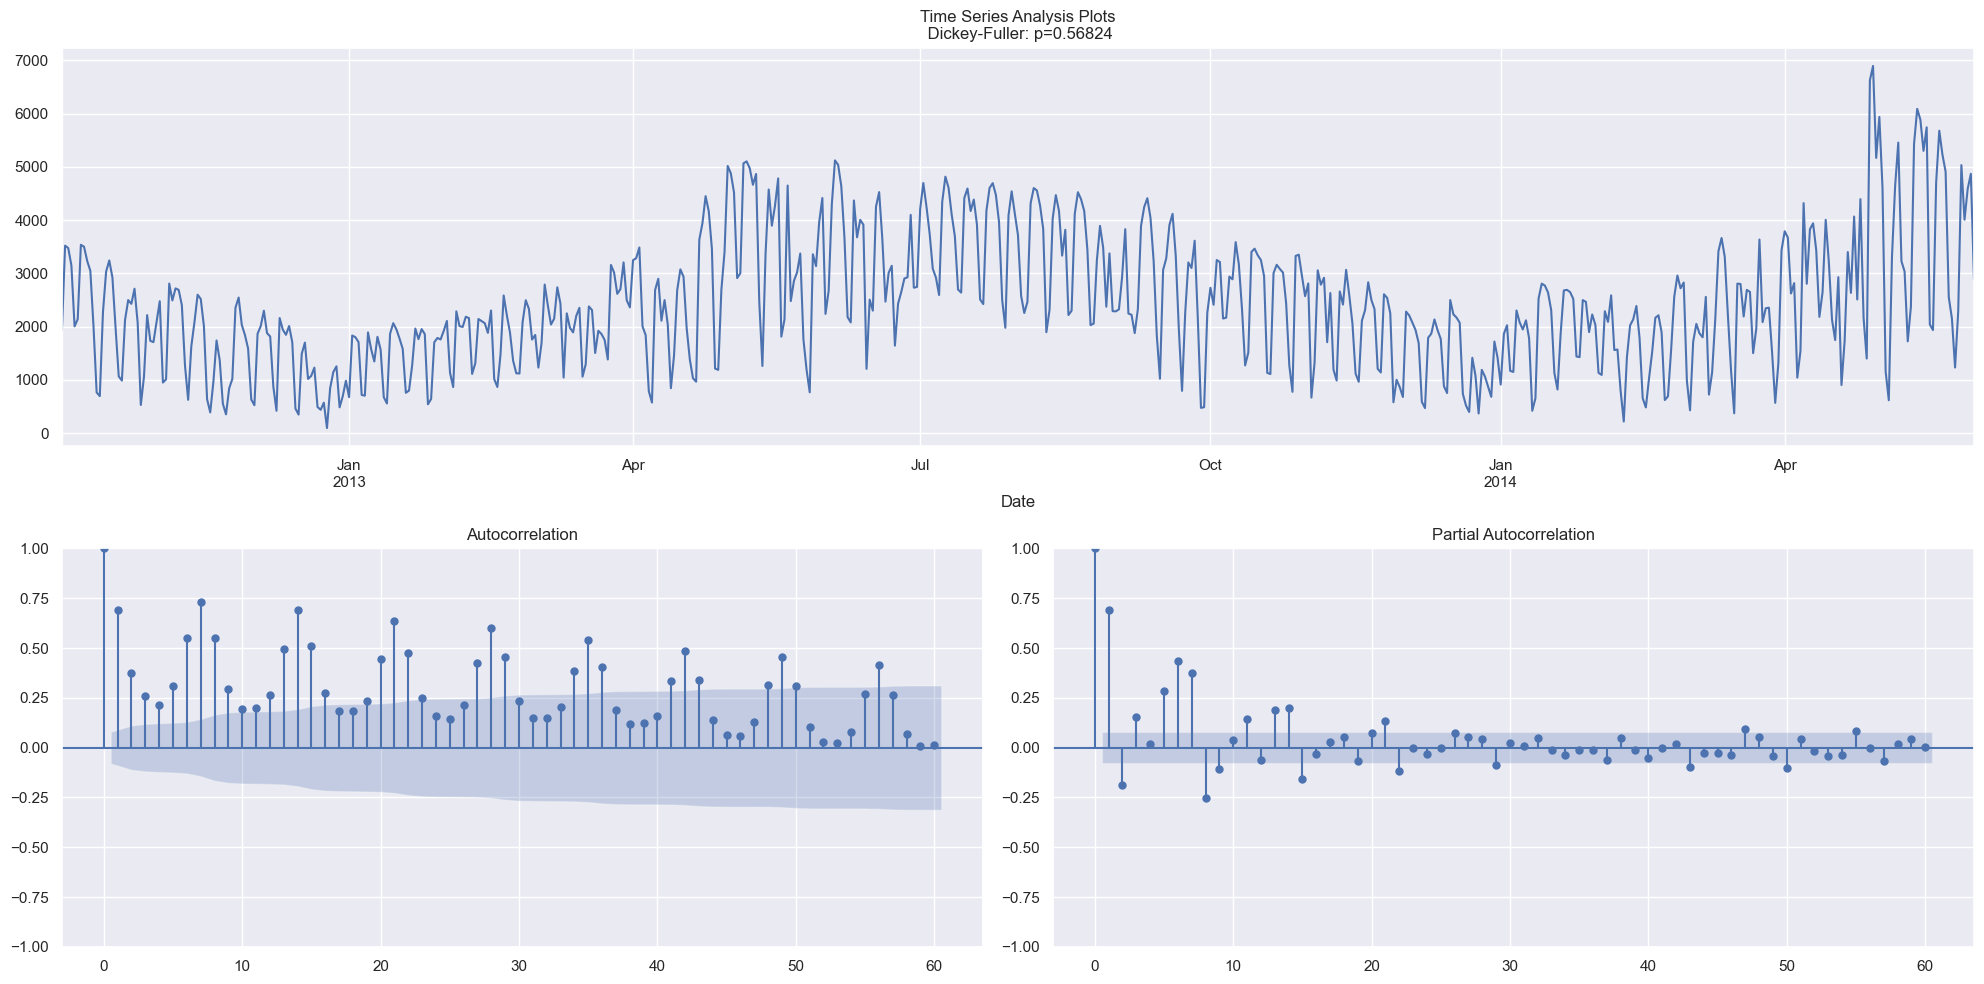

In [22]:
series = daily['total']
tsplot(series, lags=60)

In [ ]:
# Voici quelques observations des parcelles ci-dessus :

# Il n’y a pas de grandes valeurs aberrantes. Cependant, vers les jours plus récents, il semble que l'écart soit un peu plus élevé. On pourrait envisager
# de faire ici une transformation Box-Cox, mais nous l’omettrons par souci de simplicité.
# La série est clairement non stationnaire car il existe une tendance saisonnière, à savoir un modèle hebdomadaire. Ceci est clairement visible sur le
# tracé ACF. Cela signifie que nous devrons appliquer certaines différenciations afin de rendre les données plus stationnaires.

In [ ]:
# Différence saisonnière
# Nous appliquerons d’abord une différenciation saisonnière (FFP2 recommande d’appliquer d’abord une différenciation saisonnière avant de faire une
# différenciation « normale », car la différenciation normale pourrait s’avérer inutile)

In [23]:
daily_sdiff = series - series.shift(7)
daily_sdiff = daily_sdiff.dropna()

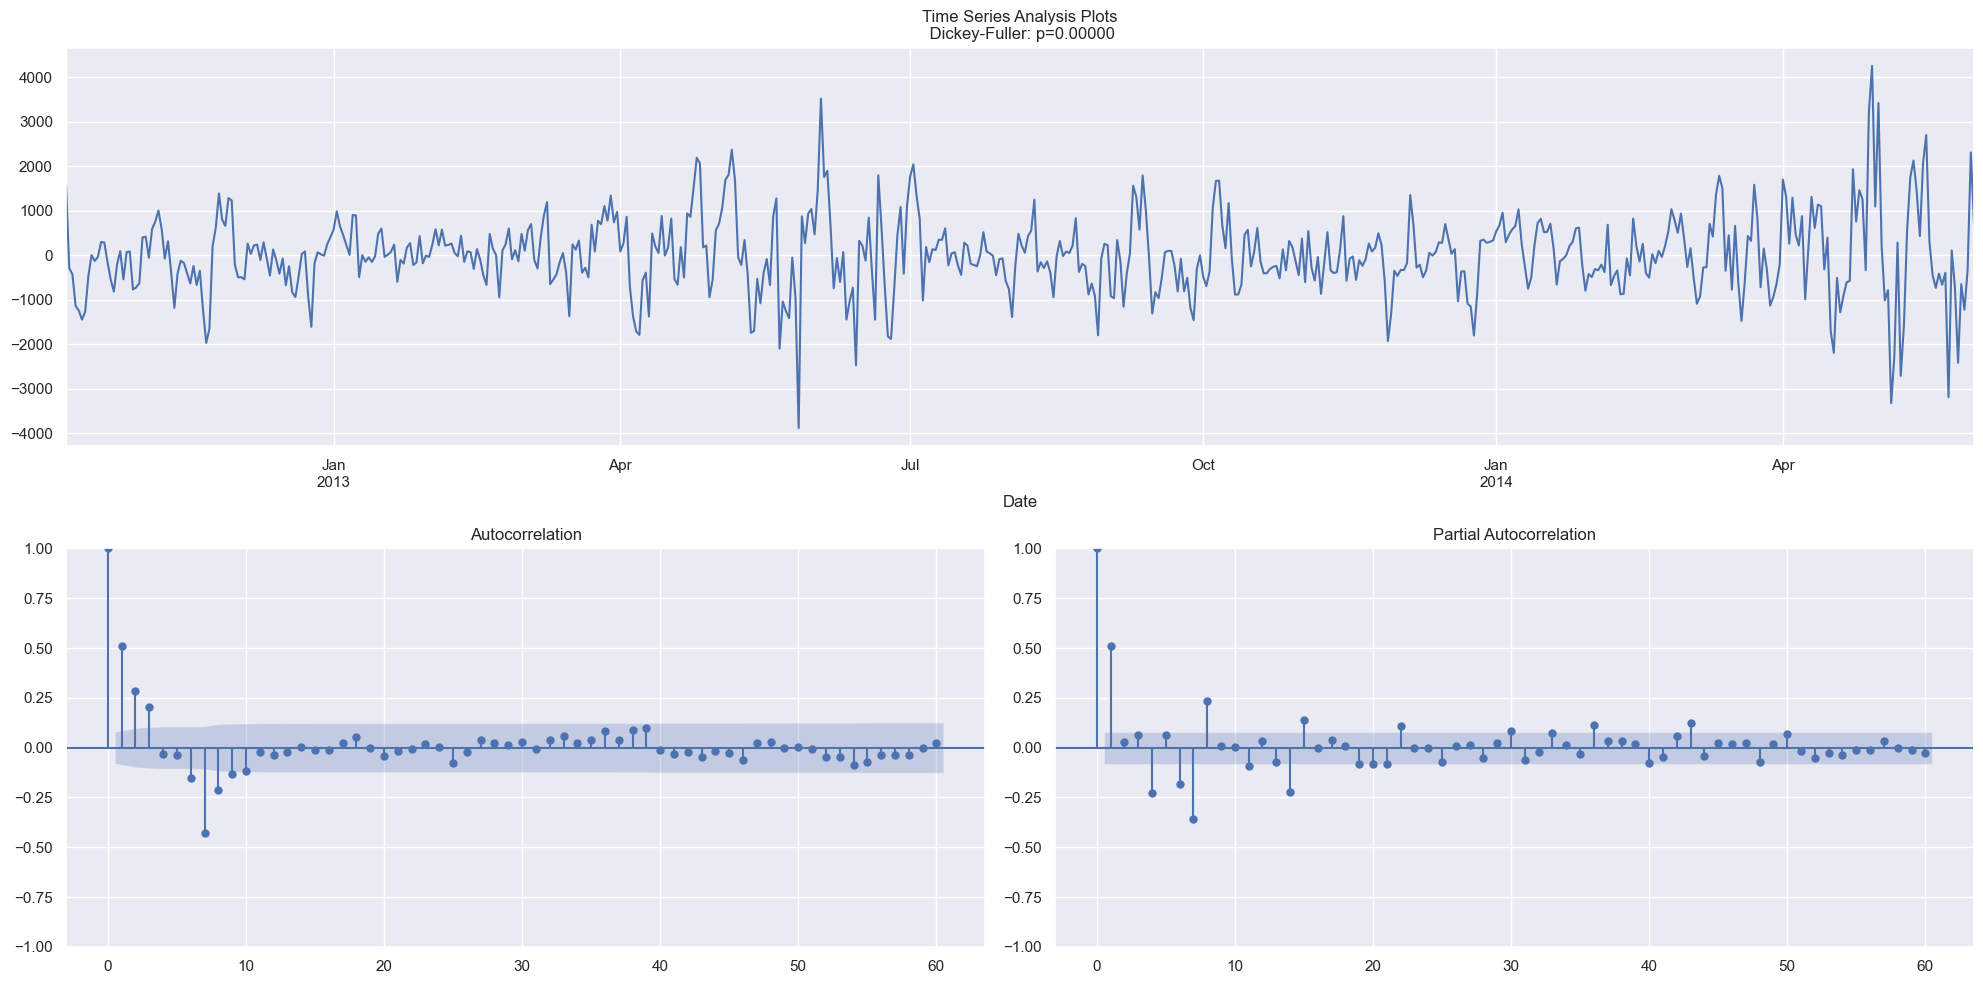

In [24]:
tsplot(daily_sdiff, lags=60)

In [ ]:
# Le test de Dickey-Fuller rejetterait l’hypothèse nulle selon laquelle la série avec différences saisonnières n’est pas stationnaire
# (la valeur p est 0). Les autocorrélations dans le tracé ACF semblent osciller un peu autour de zéro, avant de chuter à zéro. Peut-être pourrions-nous essayer une première différence (différence non saisonnière) ?

In [25]:
daily_2diffs = daily_sdiff - daily_sdiff.shift(1)
daily_2diffs = daily_2diffs.dropna()

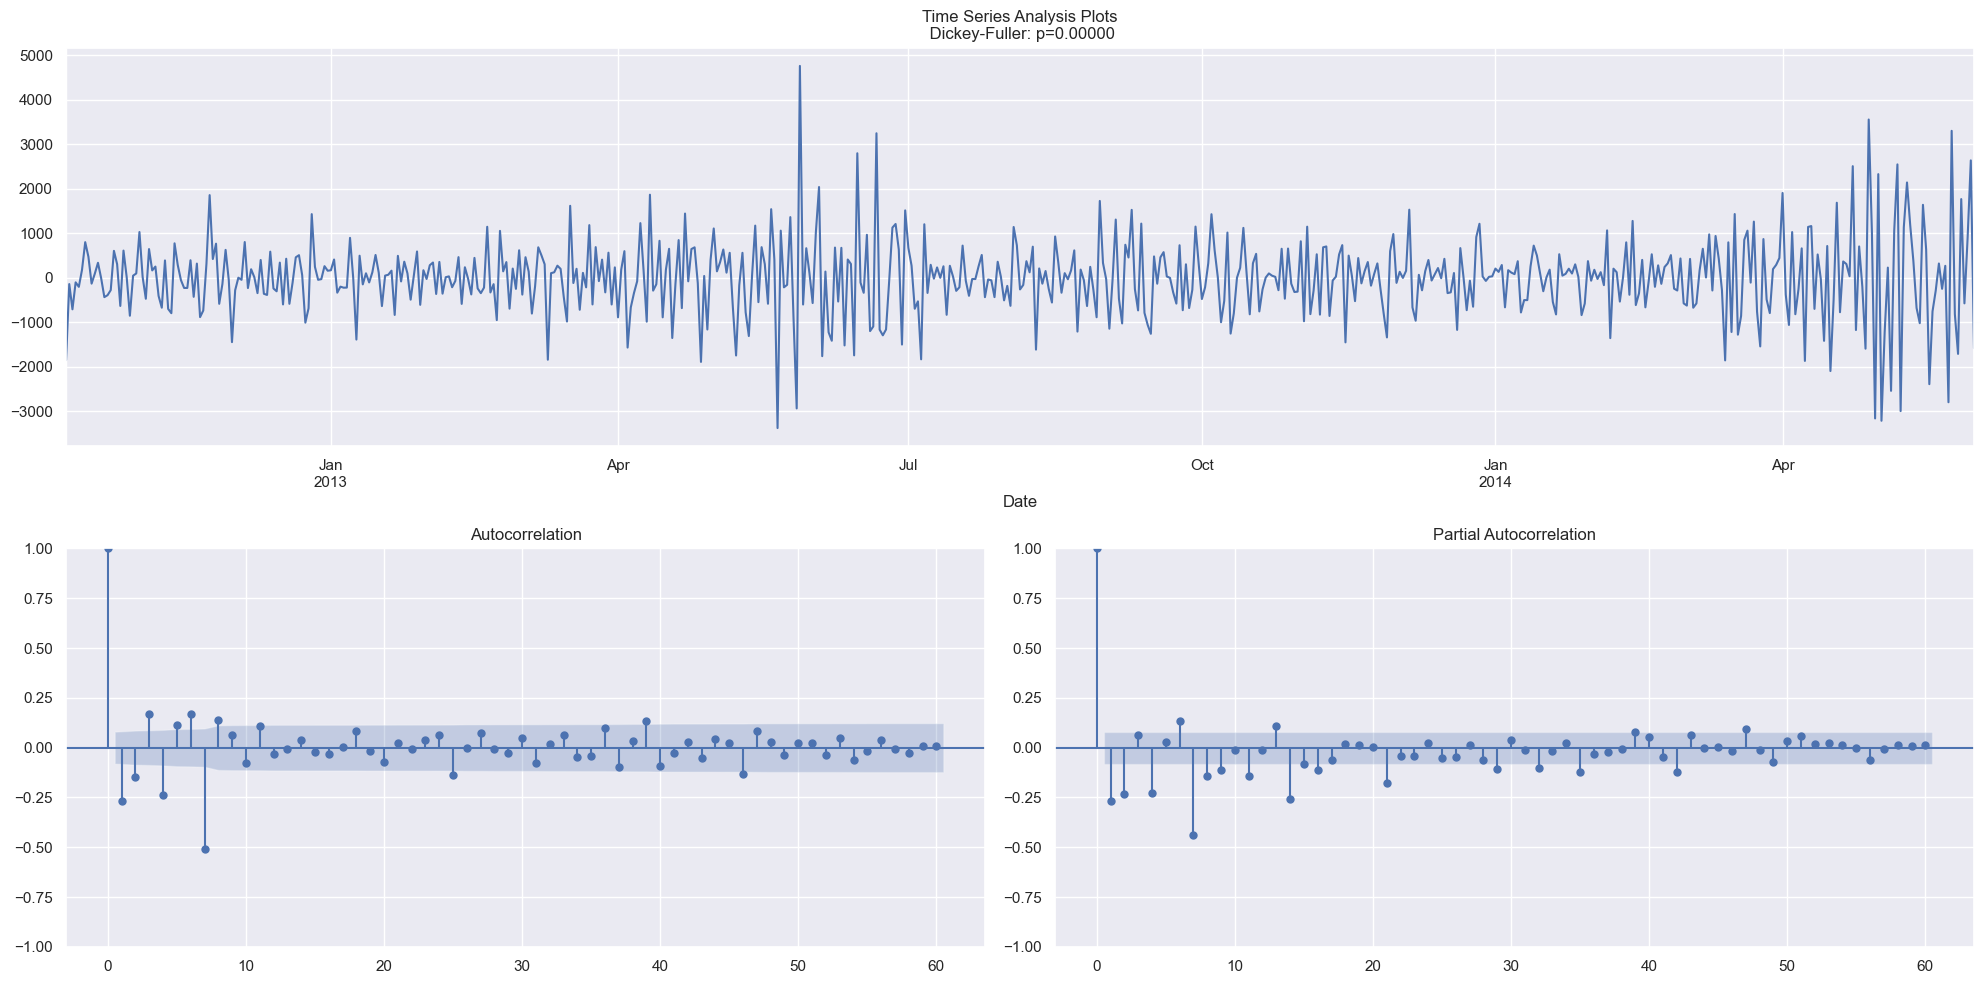

In [26]:
tsplot(daily_2diffs, lags=60)

In [ ]:
# En examinant les tracés ACF/PACF, il n’est pas tout à fait clair si la série est devenue « plus stationnaire » (le nombre de pics dans les tracés est similaire). Mais le tracé de la série temporelle après la première différenciation ressemble plus à du bruit blanc qu'au précédent. Nous allons donc utiliser les données différentielles en premier dans les sections suivantes, donc 
# d=1,D=1, pour utiliser la convention de dénomination des paramètres dans les modèles (S)ARIMA.

In [27]:
candidate_model = sm.tsa.statespace.SARIMAX(
    series, order=(0, 1, 6), seasonal_order=(0, 1, 1, 7)).fit(method='powell', disp=False)

In [28]:
candidate_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  607
Model:             SARIMAX(0, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -4671.226
Date:                             Mon, 22 Jul 2024   AIC                           9358.451
Time:                                     13:11:24   BIC                           9393.613
Sample:                                 10-02-2012   HQIC                          9372.140
                                      - 05-31-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3736      0.031    -12.124      0.000      -0.434      -0.313
ma.L2         -0.2536      0.038     -6.718      0.000      -0.328      -0.180
ma.L3         -0.0435      0.034     -1.268      0.205      -0.111       0.024
ma.L4         -0.2356      0.035     -6.642      0.000      -0.305      -0.166
ma.L5          0.0214      0.037      0.575      0.565      -0.051       0.094
ma.L6          0.0504      0.035      1.449      0.147      -0.018       0.119
ma.S.L7       -0.9311      0.015    -61.014      0.000      -0.961      -0.901
sigma2      3.395e+05   1.35e+04     25.221      0.000    3.13e+05    3.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               219.60
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Notez l'AIC du modèle dans le résumé ci-dessus (9358.451). Nous utiliserons cette métrique plus tard pour comparer différents modèles.

In [ ]:
# Diagnostic et réglage du modèle

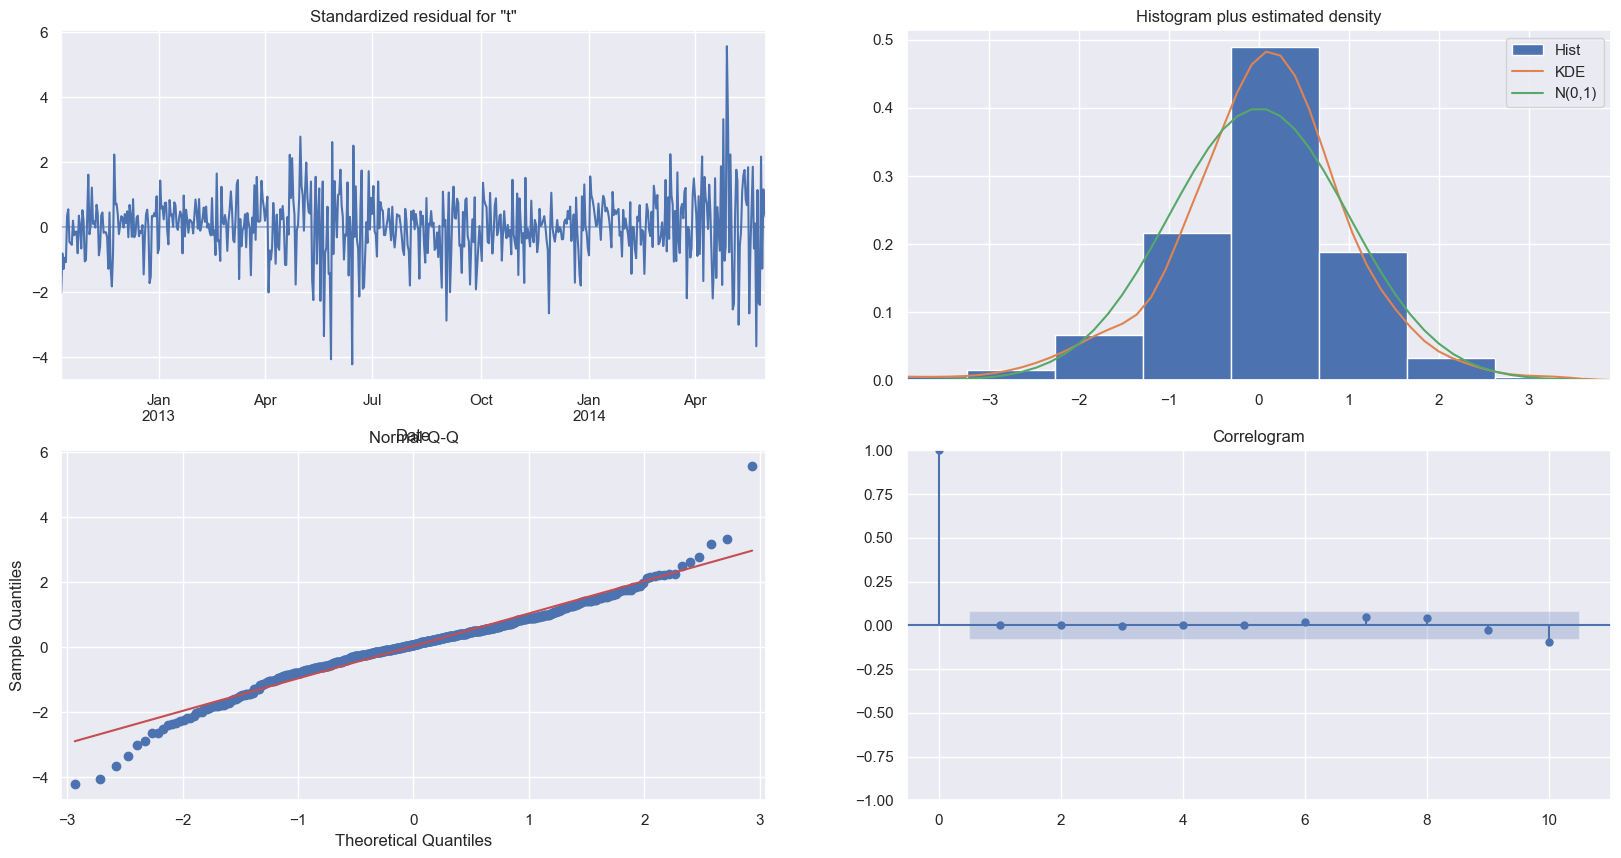

In [29]:
candidate_model.plot_diagnostics(figsize=(20,10))
plt.show()

In [ ]:
# Les résidus ressemblent à du bruit blanc et sont assez proches de la distribution normale standard. Aucune autocorrélation significative n’est visible sur le corrélogramme.
# Imprimons également les tracés ACF et PACF des résidus avec plus de décalages affichés :

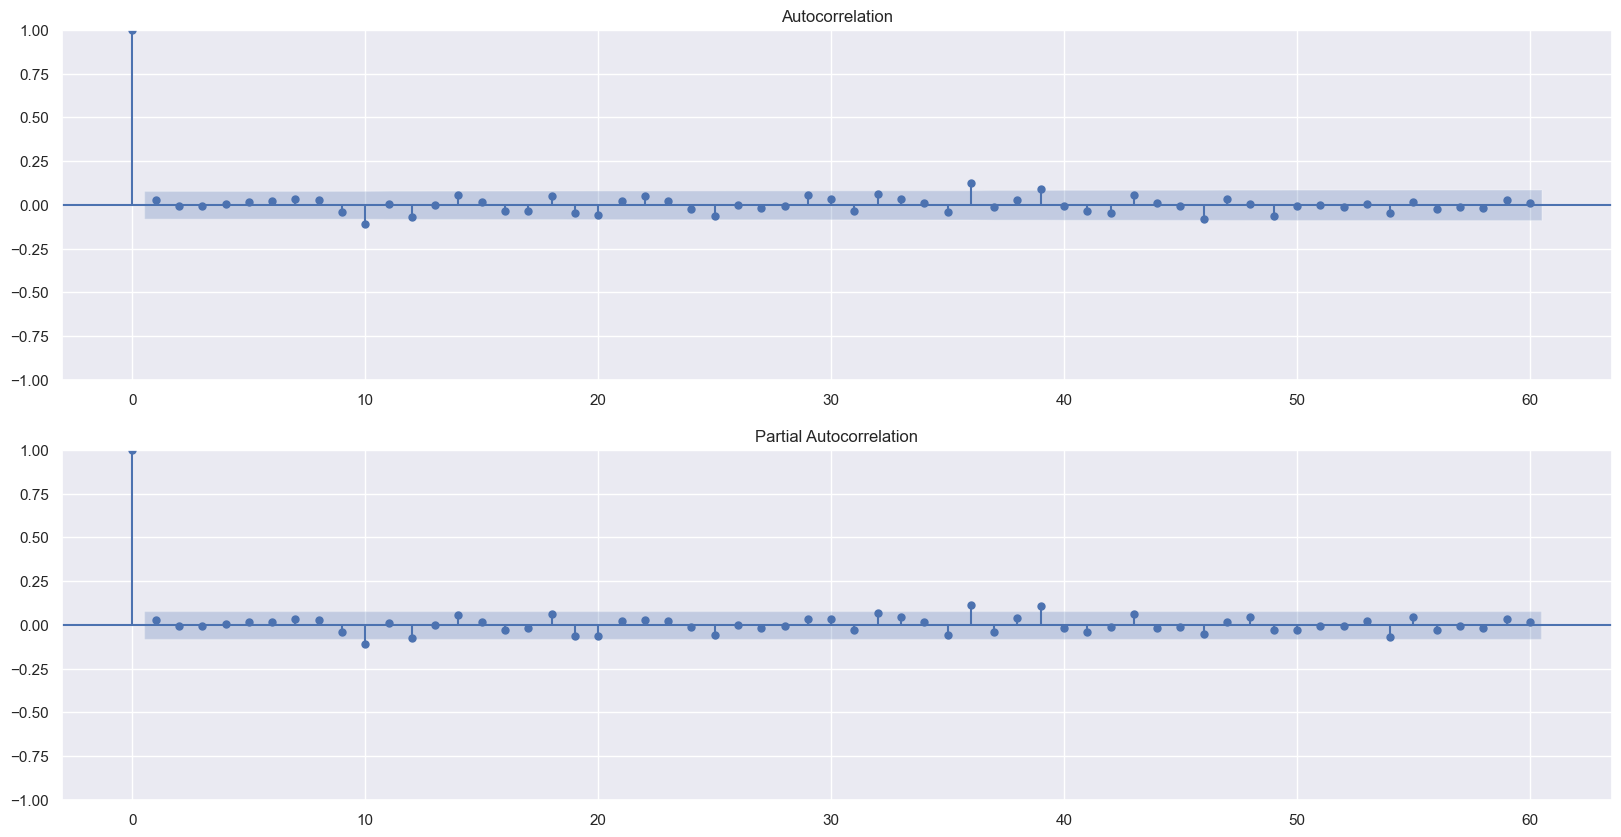

In [30]:
lags = 60
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
smts.graphics.plot_acf(candidate_model.resid, lags=lags, ax=axes[0])
smts.graphics.plot_pacf(candidate_model.resid, lags=lags, ax=axes[1])
plt.show()

In [ ]:
# Nous constatons très peu de pics significatifs dans les graphiques ACF et PACF. Cela indique que les résidus de notre modèle candidat sont
# effectivement susceptibles d'être du bruit blanc.
# En plus de vérifier les tracés, nous pouvons également effectuer un test dit-valise, en particulier le test Ljung-Box, qui, heureusement, a également une implémentation dans le package statsmodels.

In [31]:
acorr_ljungbox(candidate_model.resid, lags=[2*7], return_df=True, model_df=6)  # model_df = p + q

,lb_stat,lb_pvalue
14,15.567169,0.049011


In [ ]:
# Nous voyons que la valeur p est supérieure à 0,01 (mais inférieure à 0,05), nous ne pouvons donc pas rejeter l'hypothèse nulle selon laquelle 
# les données sont distribuées indépendamment à un niveau de signification de 0,01. Par conséquent, nous devrions être raisonnablement à l’aise avec la prévision avec ce modèle.

In [ ]:
# Sélection de modèle avec recherche par grille

In [32]:
ps = range(0, 2)
qs = range(3, 6)

p = 0
d = 1 
q = 4

Ps = range(0, 2)
Qs = range(0, 3)

P = 0
D = 1 
Q = 1
s = 7

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [33]:
def gs_arima(series, parameters_list, d, D, s, opt_method='powell'):
    """
        Return dataframe with parameters and corresponding AIC, and the best model according to AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    models = {}
    best_aic = float("inf")

    for param in parameters_list:
        # we need try-except because on some combinations model might fail to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                series, 
                order=(param[0], d, param[1]), 
                seasonal_order=(param[2], D, param[3], s)).fit(method=opt_method, disp=False)
        except:
            continue

        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table, best_model

In [34]:
result_table, best_model = gs_arima(series, parameters_list, d, D, s)

C:\Users\s.diedhiou\AppData\Local\anaconda\envs\py38\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\s.diedhiou\AppData\Local\anaconda\envs\py38\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\s.diedhiou\AppData\Local\anaconda\envs\py38\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\s.diedhiou\AppData\Local\anaconda\envs\py38\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using ze

In [35]:
result_table.head(10)

,parameters,aic
0,"(0, 4, 1, 1)",9356.886157
1,"(0, 4, 0, 1)",9357.418905
2,"(0, 4, 0, 2)",9357.463126
3,"(0, 5, 0, 1)",9357.876800
4,"(0, 5, 1, 1)",9357.878544
5,"(0, 5, 0, 2)",9358.202317
6,"(1, 4, 0, 1)",9360.101223
7,"(1, 5, 0, 1)",9360.784689
8,"(1, 5, 1, 1)",9360.925114
9,"(1, 4, 0, 2)",9361.035242


In [36]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  607
Model:             SARIMAX(0, 1, 4)x(1, 1, [1], 7)   Log Likelihood               -4671.443
Date:                             Mon, 22 Jul 2024   AIC                           9356.886
Time:                                     13:20:35   BIC                           9387.653
Sample:                                 10-02-2012   HQIC                          9368.864
                                      - 05-31-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3618      0.031    -11.843      0.000      -0.422      -0.302
ma.L2         -0.2419      0.037     -6.578      0.000      -0.314      -0.170
ma.L3         -0.0361      0.031     -1.176      0.239      -0.096       0.024
ma.L4         -0.2099      0.032     -6.459      0.000      -0.274      -0.146
ar.S.L7        0.0747      0.040      1.855      0.064      -0.004       0.154
ma.S.L7       -0.9453      0.016    -58.005      0.000      -0.977      -0.913
sigma2      3.392e+05   1.33e+04     25.589      0.000    3.13e+05    3.65e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               235.39
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

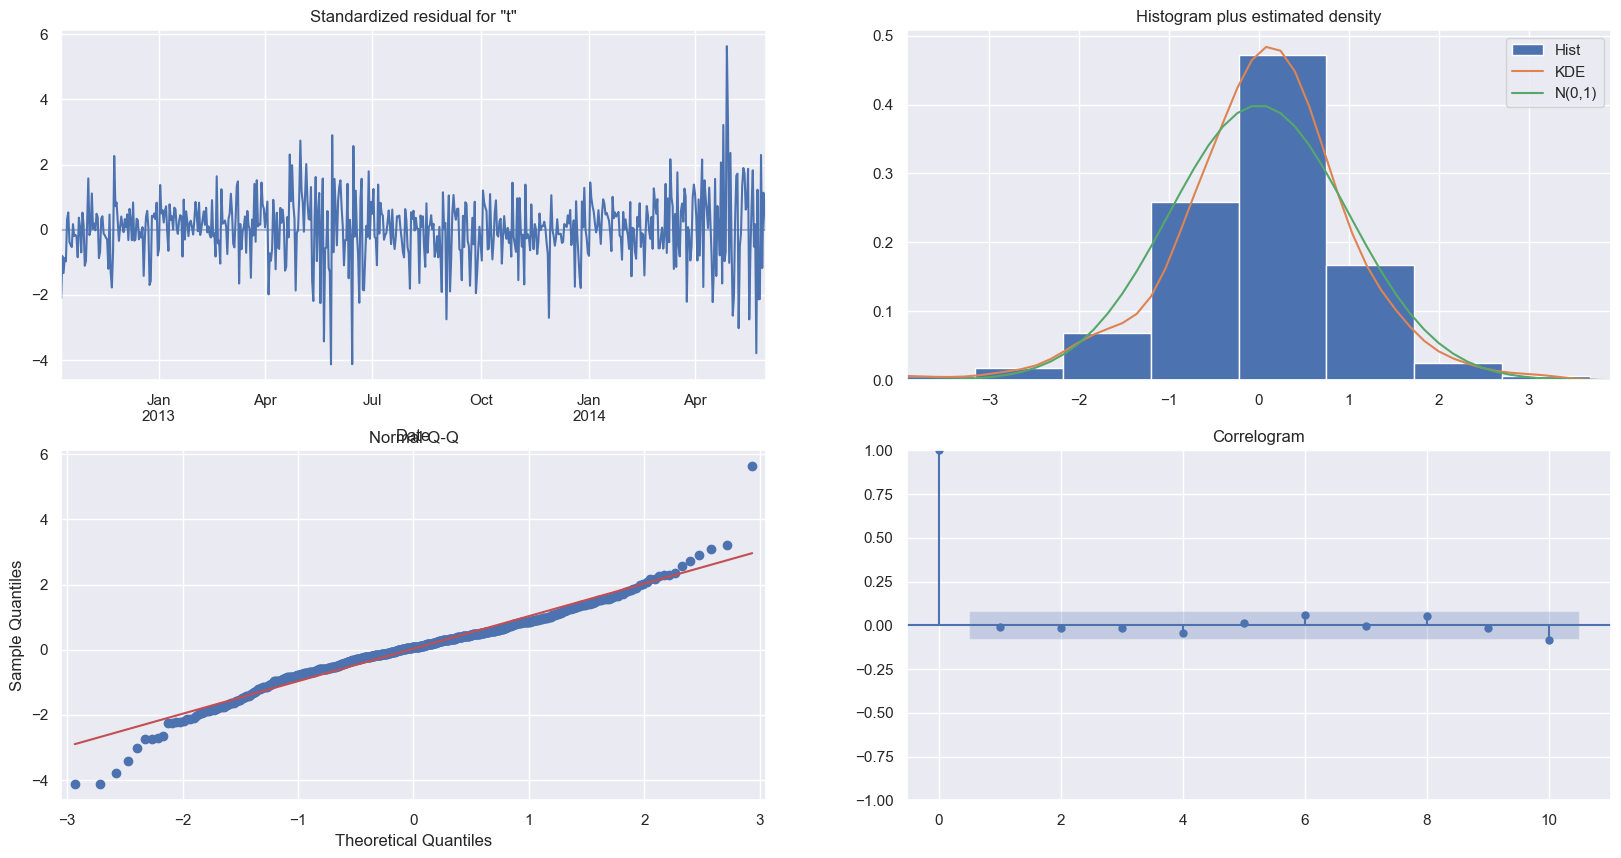

In [37]:
best_model.plot_diagnostics(figsize=(20, 10))
plt.show()

In [38]:
acorr_ljungbox(best_model.resid, lags=[2*7], return_df=True, model_df=4)  # model_df = p + q

,lb_stat,lb_pvalue
14,16.872429,0.077235


In [ ]:
# Prévisions avec le meilleur modèle

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(df, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted model
        n_steps - number of steps to predict in the future
    """
    data = df.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues

    # forecast values
    data['arima_model'][:s+d] = np.NaN
    forecast = data['arima_model']._append(model.forecast(n_steps))

    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:-n_steps], data['arima_model'][s+d:-n_steps])

    plt.figure(figsize=(20, 10))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual", alpha=0.8)
    plt.legend()
    plt.grid(True)

C:\Users\s.diedhiou\AppData\Local\Temp\ipykernel_23876\532132024.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['arima_model'][:s+d] = np.NaN


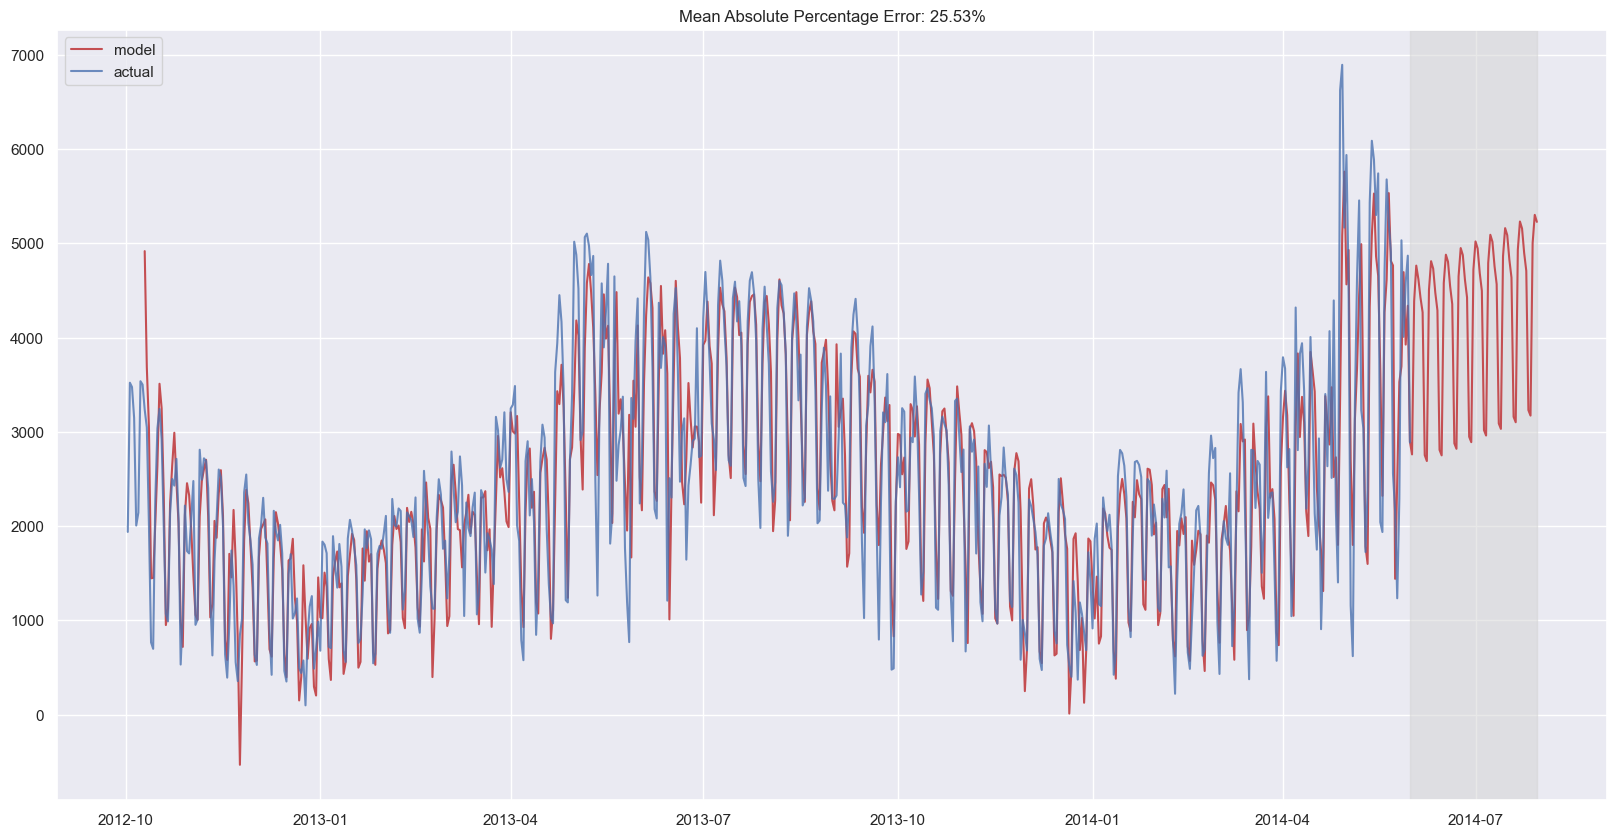

In [43]:
plot_predictions(pd.DataFrame(series), best_model, 60)